In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from astroExplain.spectra.notebook import interpret, explain_reconstruction_score

meta = MetaData()
%matplotlib inline

In [3]:
def score_name(
    score_config: dict,
) -> str:

    score = score_config['metric']
    velocity = score_config['velocity']
    relative = score_config['relative']
    percentage = score_config['percentage']

    metric = f"{score}"

    if velocity != 0:
        metric = f"{metric}_filter_{velocity}kms"

    if relative is True:

        metric = f"{metric}_rel{percentage}"
    
    else:

        metric = f"{metric}_noRel{percentage}"

    return metric

def explanation_name(lime_config: dict, fudge_config: dict) -> str:

    segmentation = lime_config['segmentation']
    n_segments = lime_config['number_segments']
    perturbation = fudge_config['kind_of_fudge']
    
    explanation_str = f"{segmentation}_{n_segments}_{perturbation}"

    if perturbation == "scale":

        scale_factor = fudge_config['scale_factor']
        explanation_str = f"{explanation_str}_{scale_factor}"

    return explanation_str

In [4]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"

In [5]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

## MSE relative

* Lack of H $\alpha$ and [OIII]$\lambda 5007$
* H $\beta$ larger than [OIII]$\lambda 5007$ and H $\alpha$
* [OIII]$\lambda 4959$ larger than [OIII]$\lambda 5007$
* Large [OII]$\lambda 3726$

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2561552092665767936&apid=


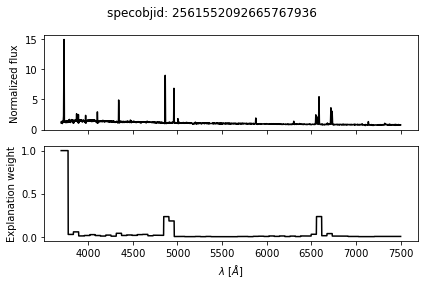

In [7]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# Load data frame with anomalies
anomaly_from_score = score_name(score_config)
# anomaly_from_score = "mse_rel100"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)

specobjid = anomalies_df.index[-28]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

* Increasing slope in blues region of the spectrum
* [-45 shape in blue], [49 no oiii 5007 but does not pay attention to it]
* [-51 shape in blue], [-65 broad line + lack of oiii 5007]


Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=619262573816080384&apid=


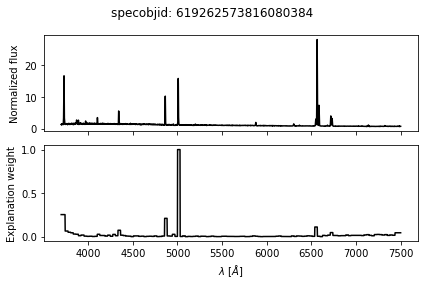

In [26]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 128,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# Load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
specobjid = anomalies_df.index[-45]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

### MSE rel after ignoring 3% of the largest residuals 

Missing values but with a score that ignores that :)

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2168559967164983296&apid=


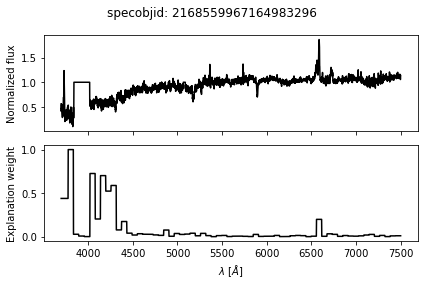

In [8]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": True,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)

specobjid = anomalies_df.index[-7]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

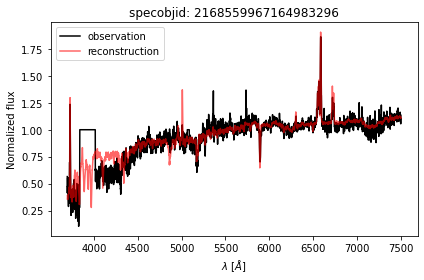

In [9]:
reconstruction = model.reconstruct(spectrum)[0]

plt.clf()

plt.plot(wave, spectrum, color="black", label="observation")
plt.plot(wave, reconstruction, color="red", alpha=0.6, label="reconstruction")
plt.legend()

plt.title(f"specobjid: {specobjid}")
plt.ylabel("Normalized flux")
plt.xlabel("$\lambda$ [$\AA$]")

# plt.tight_layout()
# plt.savefig(f"{save_to}/{specobjid}_reconstruction.pdf")

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1792523136688744448&apid=


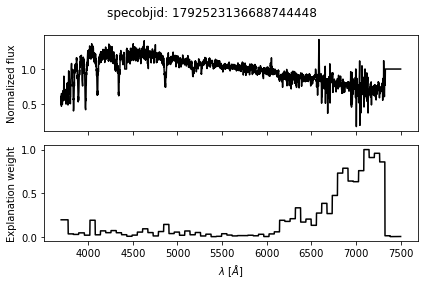

In [11]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": True,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)

specobjid = anomalies_df.index[-62]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

### MSE relative with 250 kms-1 filter

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=1007757150862206976&apid=


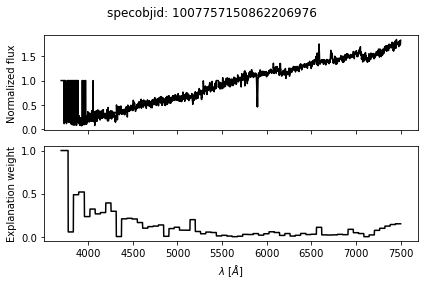

In [15]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)

specobjid = anomalies_df.index[-31]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2063788349658785792&apid=


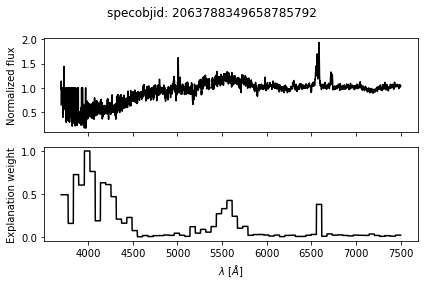

In [19]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
#33
specobjid = anomalies_df.index[-44]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2241684914279835648&apid=


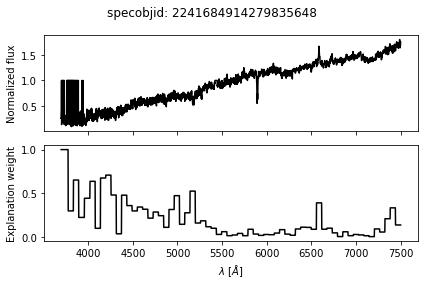

In [23]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
#33
specobjid = anomalies_df.index[-50]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=622644947132114944&apid=


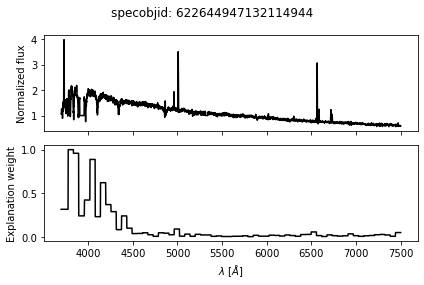

In [22]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# load data frame with anomalies
anomaly_from_score = score_name(score_config)
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
#33
specobjid = anomalies_df.index[-92]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

### MSE relative with 250 kms-1 filter after ignoring 3% of the largest residuals